In [1]:
import pandas as pd
import numpy as np
import os


In [2]:
file_path = "../../data/raw/MobiAct_combined.csv"

In [3]:
dtype_map = {
    "subject_id": "int16",
    "trial": "int16",
    "acc_x": "float32", "acc_y": "float32", "acc_z": "float32",
    "gyro_x": "float32","gyro_y": "float32","gyro_z": "float32",
    "azimuth": "float32",	"pitch": "float32",	"roll": "float32",
    "label": "category"
}

df = pd.read_csv(
    file_path,
    dtype=dtype_map,        # reduces memory footprint 
    engine='c')   

In [4]:
df

,timestamp,rel_time,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,azimuth,pitch,roll,label,subject_id,trial
0,1295405261000,0.000000,-1.407311,9.614395,-2.086666,-0.844216,0.409280,0.086437,92.746895,-36.879684,-11.741077,STD,10,1
1,1295410262000,0.005001,-1.406354,9.612960,-2.084512,-0.711047,0.346971,0.076358,92.205360,-37.470173,-11.839779,STD,10,1
2,1295415352000,0.010091,-1.405380,9.611498,-2.082320,-0.598953,0.093462,0.025045,91.743050,-38.090790,-11.880902,STD,10,1
3,1295420307000,0.015046,-1.404432,9.610076,-2.080186,-0.128893,-0.012828,-0.002443,91.267319,-38.842915,-11.933741,STD,10,1
4,1295425257000,0.019996,-1.403484,9.608654,-2.078054,0.049480,0.018326,0.016493,90.819679,-39.538643,-11.957446,STD,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16756320,10354577784000,299.969995,-0.907934,13.533889,4.335380,1.207070,-6.215859,1.962099,218.442352,-56.026966,-33.223778,WAL,9,1
16756321,10354582775000,299.974986,-1.867024,12.331459,2.439285,0.968221,-6.103155,1.773953,220.688690,-57.077301,-31.897688,WAL,9,1
16756322,10354588060000,299.980271,-2.924407,11.485553,0.782717,0.740674,-6.034738,1.459663,222.816406,-58.044624,-30.614605,WAL,9,1
16756323,10354592749000,299.984960,-3.726923,11.084407,-0.258194,0.536645,-5.905845,1.027781,224.671646,-58.777103,-29.624798,WAL,9,1


In [5]:

fall_labels = ['BSC', 'FKL', 'SDL', 'FOL']
post_fall = ['LYI']

df['fall_label'] = df['label'].apply(
    lambda x: 'FALL' if x in fall_labels else ('POST_FALL' if x in post_fall else 'ADL')
)


In [6]:
import scipy.signal as signal
def apply_low_pass_filter(data, cutoff=3, fs=10, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    df_filtered = data.copy()
    for col in ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']:
        df_filtered[col] = signal.filtfilt(b, a, data[col])
    return df_filtered


In [7]:
df = apply_low_pass_filter(df)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'azimuth','pitch','roll']
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])

In [9]:
X = df[sensor_cols]
y = df['fall_label']

### Extract window / Label data based on dynamic window

In [10]:
from typing import Tuple, List

def sliding_multi_window(
    X: np.ndarray,
    y: np.ndarray,
    fs: int = 200,
    subwindow_duration: float = 0.2,
    overlap: float = 0.5,
    include_post_fall: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Implements label-based main windows with fixed-size, overlapping sub-windows.
    
    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
        Time-series sensor data (e.g., acc_x, acc_y, ..., gyro_z).
    y : np.ndarray, shape (n_samples,)
        Frame-level labels: 'ADL', 'FALL', 'POST_FALL', etc.
    fs : int
        Sampling rate in Hz (e.g., 200).
    subwindow_duration : float
        Duration of each sub-window in seconds (e.g., 0.2).
    overlap : float
        Fractional overlap between sub-windows (0 to <1, e.g., 0.5 for 50%).
    include_post_fall : bool
        If True, emits 'POST_FALL' windows; if False, merges POST_FALL into 'FALL'.
    
    Returns
    -------
    X_sub : np.ndarray, shape (n_subwindows, window_size, n_features)
        Array of all extracted sub-windows.
    y_sub : np.ndarray, shape (n_subwindows,)
        Corresponding labels for each sub-window.
    """
    # Compute window parameters
    window_size = int(fs * subwindow_duration)
    step_size = int(window_size * (1 - overlap))
    if step_size < 1:
        raise ValueError("Overlap too large: step size <1 sample.")
    
    # Ensure proper indexing
    X_arr = np.asarray(X)
    y_arr = np.asarray(y)
    
    X_sub, y_sub = [], []
    
    # Helper to slice sub-windows within a main segment
    def emit_windows(segment: np.ndarray, label: str):
        for start in range(0, len(segment) - window_size + 1, step_size):
            end = start + window_size
            X_sub.append(segment[start:end])
            y_sub.append(label)
    
    # Find contiguous main windows by label
    curr_label = y_arr[0]
    seg_start = 0
    for i in range(1, len(y_arr)):
        if y_arr[i] != curr_label:
            segment = X_arr[seg_start:i]
            if curr_label == "ADL":
                emit_windows(segment, "ADL")
            elif curr_label == "FALL":
                emit_windows(segment, "FALL")
            elif curr_label == "POST_FALL":
                if include_post_fall:
                    emit_windows(segment, "POST_FALL")
                else:
                    emit_windows(segment, "FALL")
            # start next main window
            seg_start = i
            curr_label = y_arr[i]
    
    # Handle the last main window
    segment = X_arr[seg_start:]
    if curr_label == "ADL":
        emit_windows(segment, "ADL")
    elif curr_label == "FALL":
        emit_windows(segment, "FALL")
    elif curr_label == "POST_FALL":
        if include_post_fall:
            emit_windows(segment, "POST_FALL")
        else:
            emit_windows(segment, "FALL")
    
    return np.stack(X_sub, axis=0), np.array(y_sub)

In [ ]:
X_windows, y_windows = sliding_multi_window(X, y, fs =200,subwindow_duration=0.4, overlap=0.5,include_post_fall=False)

In [28]:
pd.DataFrame(y_windows).value_counts()

0   
ADL     306463
FALL     25266
Name: count, dtype: int64

### Train/val/test split

In [29]:
from sklearn.model_selection import train_test_split

# 1) First split off the test set (e.g., 20% of the data):
X_temp, X_test, y_temp, y_test = train_test_split(
    X_windows,
    y_windows,
    test_size=0.2,
    stratify=y_windows,
    random_state=42
)

# 2) Now split the remaining ‘temp’ into train and val (e.g., 10% of original → 12.5% of temp):
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.125,            # so that val ≈ 0.125 of temp → 0.1 of total
    stratify=y_temp,
    random_state=42
)


In [30]:
pd.DataFrame(y_train).value_counts()

0   
ADL     214524
FALL     17686
Name: count, dtype: int64

### Encode variables

In [31]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)


In [32]:
# Ensure they are NumPy arrays
y_train_encoded = np.array(y_train_encoded)
y_val_encoded = np.array(y_val_encoded)
y_test_encoded = np.array(y_test_encoded)

### Encode Label

In [33]:
X_train.shape

(232210, 100, 9)

In [34]:
import tensorflow as tf
from tensorflow.keras.losses import Loss

class SparseCategoricalFocalLoss(Loss):
    def __init__(self, gamma=2., alpha=1., from_logits=False, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])

        if self.from_logits:
            y_pred = tf.nn.softmax(y_pred)

        pt = tf.reduce_sum(y_pred * y_true_one_hot, axis=-1)
        loss = -self.alpha * tf.pow(1. - pt, self.gamma) * tf.math.log(tf.clip_by_value(pt, 1e-8, 1.0))
        return tf.reduce_mean(loss)


In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

# Implementation of "LSTM-CNN Architecture for Human Activity Recognition" by Kun Xia et al. (IEEE Access, 2020)
# Adapted from https://github.com/quotation2520/CAGE4HAR/blob/main/models/LSTM_CNN.py

## X_train_windows.shape == (n_samples, 100, 6)
input_shape = (X_train.shape[1], X_train.shape[2]) 
num_classes = len(set(y_train_encoded))                  

model_lstm_conv = Sequential([

    # ——— LSTM stack ———
    # first LSTM returns full sequence
    LSTM(32, return_sequences=True, input_shape=input_shape),
    # second LSTM also returns full sequence
    LSTM(32, return_sequences=True),

    # ——— 1D‐Conv + Pool ———
    Conv1D(
        filters=64,
        kernel_size=3,
        strides=2,
        activation='relu',
        padding='valid'   # matches PyTorch default
    ),
    MaxPooling1D(pool_size=2, strides=2),

    # ——— second Conv block ———
    Conv1D(
        filters=128,
        kernel_size=3,
        strides=1,
        activation='relu',
        padding='valid'
    ),

    # ——— batch‐norm & spatial collapse ———
    BatchNormalization(),            # normalise over feature‐axis
    GlobalAveragePooling1D(),        # mean over time dimension

    # ——— classification head ———
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_lstm_conv.compile(
    optimizer=Adam(1e-3),
    loss=SparseCategoricalFocalLoss(gamma=2., alpha=1.0),
    metrics=['accuracy']
)

model_lstm_conv.summary()

c:\Users\sovan\Desktop\Fall Detection\New ilab\ilab-group-12-1-fall-detection\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100, 32)        │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 49, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 22, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,378 (177.26 KB)

 Trainable params: 45,122 (176.26 KB)

 Non-trainable params: 256 (1.00 KB)

In [36]:
history = model_lstm_conv.fit(
    X_train, y_train_encoded,
    validation_data=(X_val, y_val_encoded),
    epochs=20,
    batch_size=64
)

Epoch 1/20
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 275s 74ms/step - accuracy: 0.9222 - loss: 0.0561 - val_accuracy: 0.9599 - val_loss: 0.0286
Epoch 2/20
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 272s 75ms/step - accuracy: 0.9616 - loss: 0.0270 - val_accuracy: 0.9682 - val_loss: 0.0227
Epoch 3/20
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 269s 74ms/step - accuracy: 0.9695 - loss: 0.0220 - val_accuracy: 0.9734 - val_loss: 0.0199
Epoch 4/20
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 269s 74ms/step - accuracy: 0.9732 - loss: 0.0197 - val_accuracy: 0.9755 - val_loss: 0.0178
Epoch 5/20
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 268s 74ms/step - accuracy: 0.9761 - loss: 0.0175 - val_accuracy: 0.9770 - val_loss: 0.0171
Epoch 6/20
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 258s 71ms/step - accuracy: 0.9782 - loss: 0.0162 - val_accuracy: 0.9793 - val_loss: 0.0153
Epoch 7/20
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 232s 64ms/step - accuracy: 0.9801 - loss: 0.0148 - val_accuracy: 0.9797 - val_loss: 0.0152
Epoch 8/20
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 204s 56ms/step - accuracy: 

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)


def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=False):
    # Evaluate the model
    results = model.evaluate(X_test, y_test, verbose=0)
    metric_names = model.metrics_names
    metrics_dict = dict(zip(metric_names, results))

    print("Evaluation Metrics:")
    for name, value in metrics_dict.items():
        print(f"{name.capitalize()}: {value:.4f}")

    # Predict class probabilities and take argmax for predicted class
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100  # row-wise normalization

    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues',
                    xticklabels=label_classes if label_classes else np.unique(y_test),
                    yticklabels=label_classes if label_classes else np.unique(y_test))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix (%)")
        plt.show()

    # Classification report
    report = classification_report(y_test, y_pred, target_names=label_classes if label_classes else None)
    print("Classification Report:\n", report)

    # Macro-averaged metrics across all classes
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    print("Macro Precision (sklearn): {:.4f}".format(precision))
    print("Macro Recall (sklearn): {:.4f}".format(recall))
    print("Macro F1 Score: {:.4f}".format(f1))

    # Update metrics dictionary to include sklearn metrics
    metrics_dict.update({
        'macro_precision': precision,
        'macro_recall': recall,
        'macro_f1_score': f1
    })

    return metrics_dict

Evaluation Metrics:
Loss: 0.0102
Compile_metrics: 0.9866
2074/2074 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step


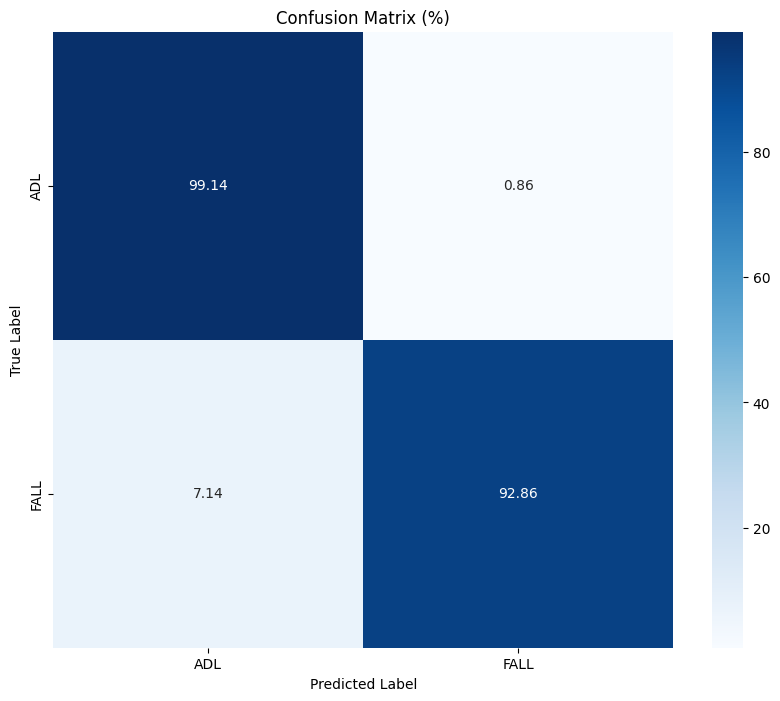

Classification Report:
               precision    recall  f1-score   support

         ADL       0.99      0.99      0.99     61293
        FALL       0.90      0.93      0.91      5053

    accuracy                           0.99     66346
   macro avg       0.95      0.96      0.95     66346
weighted avg       0.99      0.99      0.99     66346

Macro Precision (sklearn): 0.9467
Macro Recall (sklearn): 0.9600
Macro F1 Score: 0.9532


In [44]:
label_classes = le.classes_.tolist()
metrics = evaluate_model(model_lstm_conv, X_test, y_test_encoded, label_classes=label_classes)


### 10-Fold Cross Validation

In [ ]:
def create_model(input_shape, num_classes):
    model = Sequential([
        LSTM(32, return_sequences=True, input_shape=input_shape),
        LSTM(32, return_sequences=True),
        Conv1D(64, kernel_size=3, strides=2, activation='relu', padding='valid'),
        MaxPooling1D(pool_size=2, strides=2),
        Conv1D(128, kernel_size=3, strides=1, activation='relu', padding='valid'),
        BatchNormalization(),
        GlobalAveragePooling1D(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(1e-3),
        loss=SparseCategoricalFocalLoss(gamma=2., alpha=1.0),
        metrics=['accuracy']
    )
    return model


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

fold_precisions = []
fold_recalls = []
fold_f1s = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train_encoded)):
    print(f"\n🟦 Fold {fold+1}")

    # Split the data
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train_encoded[train_idx], y_train_encoded[val_idx]

    # Create and train the model
    model = create_model(input_shape, num_classes)
    model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        verbose=1
    )

    # Predict
    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate metrics
    precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)

    print(f"✅ Fold {fold+1} Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1s.append(f1)


In [ ]:
print(f"\n📊 Mean Precision: {np.mean(fold_precisions):.4f} ± {np.std(fold_precisions):.4f}")
print(f"📊 Mean Recall:    {np.mean(fold_recalls):.4f} ± {np.std(fold_recalls):.4f}")
print(f"📊 Mean F1 Score:  {np.mean(fold_f1s):.4f} ± {np.std(fold_f1s):.4f}")